## TASK 2.1
Development of a classification model for discriminating between 2 classes: masses and calcification. Design and development of an ad-hoc CNN architecture (training from scratch).

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import os
import itertools
import csv
import numpy as np
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task2_1') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 64
COUNT = 0

# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


### Utility function definition
This section defines all the utility functions that will be used in the rest of the notebook.

#### Loading training and test sets

In [3]:
# Loading training set and test set
def load_training():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels


#### Printing of confusion matrix

In [4]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Trend printing of accuracy and loss functions

In [5]:
# Utility function for plotting accuracy and loss function
def performance_plot(history, model):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    results = model.evaluate(valid_images, valid_labels, batch_size=BATCH_SIZE)
    print("Validation accuracy and loss of the best model")
    print("Validation loss, Validation acc:", results)

    pred_labels = model.predict(test_images)
    pred_labels = np.rint(pred_labels)

    print(classification_report(test_labels, pred_labels, digits=4))

    cm = confusion_matrix(test_labels, pred_labels)
    plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

    probs = model.predict_proba(test_images)
    
    fig2 = plt.figure()
    fpr, tpr, threshold = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Seed settings

In [6]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

#### Model run

In [7]:
# Function for running different models with different parameters
def run_model(model, model_name, epoch = 100, adam = False, learning_rate = 0.0001):
  if not adam:
    model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  else:
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['acc'])
    
  model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, model_name + '_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

  history = model.fit(
    train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=epoch,
    validation_data = validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
    )
  
  models.save_model(model, os.path.join(MODEL_PATH, model_name+'.h5'))
  
  best_model = models.load_model(os.path.join(MODEL_PATH, model_name + '_best.h5'))

  performance_plot(history, best_model)
  


#### Contrast stretching

In [ ]:
# Modifying image contrast
def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2,98))
    img_modified = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_modified

### Dataset creation
We take the original dataset with five labels: we discard the label '0', which correspond to baseline patch, because we are considering only the abnormalities, and we aggregate label '1' and '2', which both correspond to masses, and label '3' and '4', which are both calcifications.


In [8]:
train_img, train_lab = load_training()
test_img, test_lab = load_test()

In [9]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') / 65535

# mass
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 2] = 0
# calcification
abnormality_labels[abnormality_labels == 3] = 1
abnormality_labels[abnormality_labels == 4] = 1


# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)


# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') / 65535

# mass
test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 0
# calcification
test_labels[test_labels == 3] = 1
test_labels[test_labels == 4] = 1


print("Original training set")
print(abnormality_labels.shape)
print(abnormality_images.shape)
print("Training set")
print(train_labels.shape)
print(train_images.shape)
print("Validation set")
print(valid_labels.shape)
print(valid_images.shape)
print("Test set")
print(test_labels.shape)
print(test_images.shape)

Original training set
(2676,)
(2676, 150, 150, 1)
Training set
(1873,)
(1873, 150, 150, 1)
Validation set
(803,)
(803, 150, 150, 1)
Test set
(336,)
(336, 150, 150, 1)


### Variability analysis
Due to the use of GPU, it is not possible to have the same results with consequent running of one model. Hence, we perform a variability analysis considering 12 executions of the same model and another 12 executions of the same model with Early stopping and saving the best model.
<div>
<img src="https://drive.google.com/uc?export=view&id=1-MZztqyNk5ckfllBZQ6VnaGr-rNvg7ZQ" alt="Drawing" width="400"/>
</div>
<div>
<img src="https://drive.google.com/uc?export=view&id=1-DltMogMcqd3MLXVxWqrBwcwFb4R4Ah-" alt="Drawing" width="400"/>
</div>

It seems that with the Early stopping and saving the best model we reduce the results variability in both validation and test.



### Experiment 1
We try with a simple network constituted by two convolutional layers and two dense layers at the end.

In this experiment we do not consider data augmentation.

In [13]:
train_datagen = ImageDataGenerator()

datagen = ImageDataGenerator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1327120   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

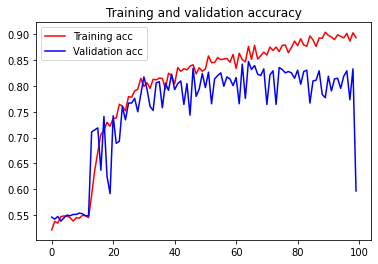

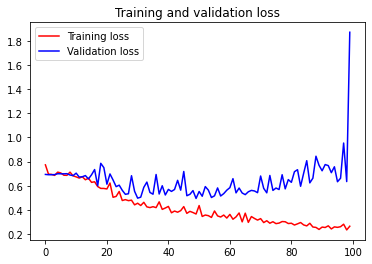

13/13 [==============================] - 0s 19ms/step - loss: 0.4894 - acc: 0.8269
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.48941126465797424, 0.8268991112709045]
              precision    recall  f1-score   support

           0     0.7835    0.8492    0.8150       179
           1     0.8099    0.7325    0.7692       157

    accuracy                         0.7946       336
   macro avg     0.7967    0.7908    0.7921       336
weighted avg     0.7958    0.7946    0.7936       336



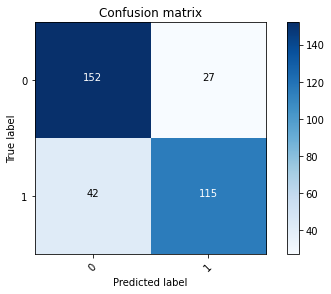

In [ ]:
set_seed()

datagen.fit(train_images)
train_generator = datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
run_model(model, 'model')

### Experiment 2
Given the result obtained in the previous experiment, we add data augmentation in order to eliminate or decrease overfitting.
As data augmentation, we only consider 180 rotation and vertical and horizontal flips.

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1327120   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

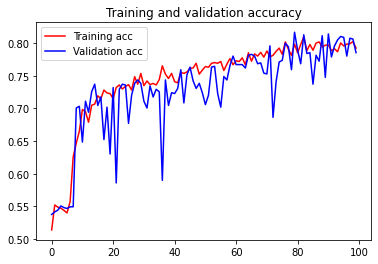

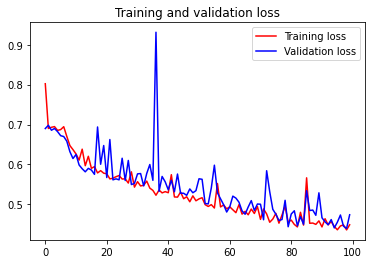

13/13 [==============================] - 0s 13ms/step - loss: 0.4358 - acc: 0.8082
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.43576282262802124, 0.8082191944122314]
              precision    recall  f1-score   support

           0     0.7831    0.8268    0.8043       179
           1     0.7891    0.7389    0.7632       157

    accuracy                         0.7857       336
   macro avg     0.7861    0.7828    0.7838       336
weighted avg     0.7859    0.7857    0.7851       336



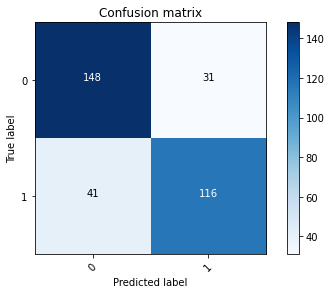

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()
run_model(model2, 'model2')


### Experiment 3
Given the poor performance stability of the previous experiment using 'rmsprop' as an optimiser, we try changing it to adam and setting the learning rate to the default value.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1327120   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

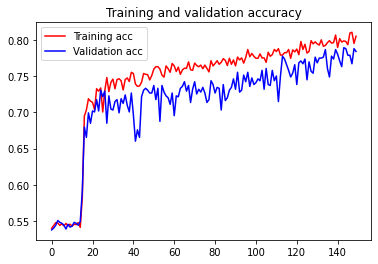

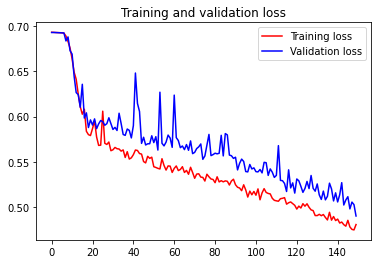

13/13 [==============================] - 0s 13ms/step - loss: 0.4932 - acc: 0.7808
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.4931894540786743, 0.7808219194412231]
              precision    recall  f1-score   support

           0     0.7824    0.7430    0.7622       179
           1     0.7229    0.7643    0.7430       157

    accuracy                         0.7530       336
   macro avg     0.7526    0.7537    0.7526       336
weighted avg     0.7546    0.7530    0.7532       336



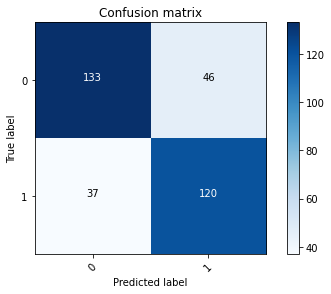

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.summary()

run_model(model3, 'model3', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 4
Applying adam actually made the trend more stable, so we want to try and make it converge sooner and to do this we use BatchNormalization using the default momentum.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0

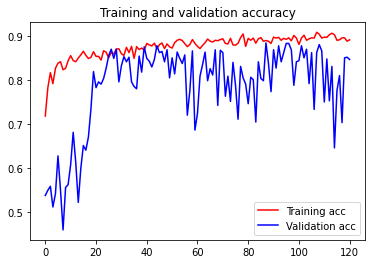

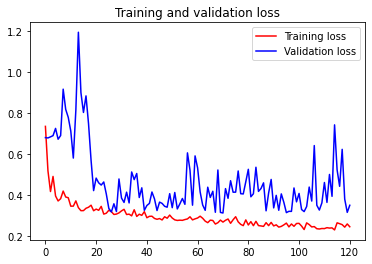

13/13 [==============================] - 0s 22ms/step - loss: 0.3374 - acc: 0.8605
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.3373715579509735, 0.8605230450630188]
              precision    recall  f1-score   support

           0     0.8938    0.7989    0.8437       179
           1     0.7955    0.8917    0.8408       157

    accuracy                         0.8423       336
   macro avg     0.8446    0.8453    0.8422       336
weighted avg     0.8478    0.8423    0.8423       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


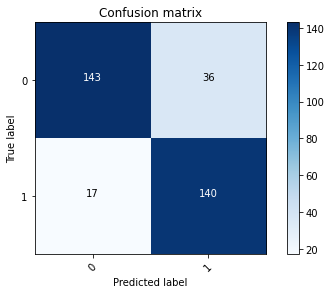

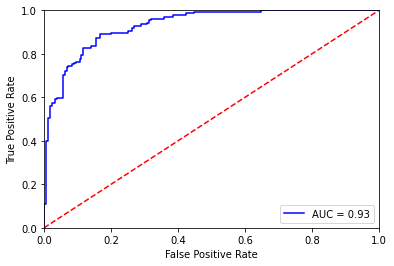

In [15]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.summary()

run_model(model4, 'model4', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 5
As we can see from the result of the BatchNormalization experiment we get a trend of accuracy and loss with many fluctuations perhaps due to a slight overfitting, so we try to add the l2 regularization to remove it.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0

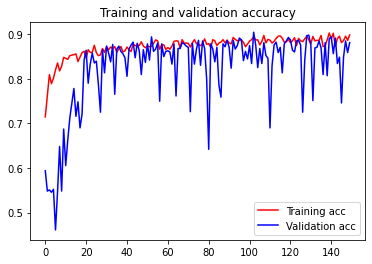

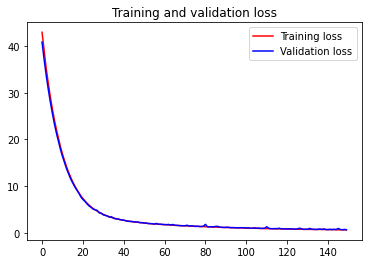

13/13 [==============================] - 0s 16ms/step - loss: 0.6604 - acc: 0.8892
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.6603579521179199, 0.8891656398773193]
              precision    recall  f1-score   support

           0     0.9000    0.8547    0.8768       179
           1     0.8434    0.8917    0.8669       157

    accuracy                         0.8720       336
   macro avg     0.8717    0.8732    0.8718       336
weighted avg     0.8735    0.8720    0.8722       336



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


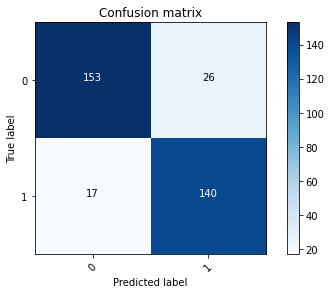

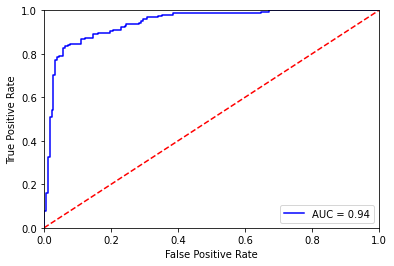

In [17]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(1)))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1)))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dense(16, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))
model5.summary()

run_model(model5, 'model5', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 6
Even with l2 regularisation, the accuracy trend does not improve, so we can assume that BatchNormalisation is not useful for the purpose of this task.

Starting from experiment 3 we try to change the network by increasing the dense layer from 16 to 64.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5308480   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

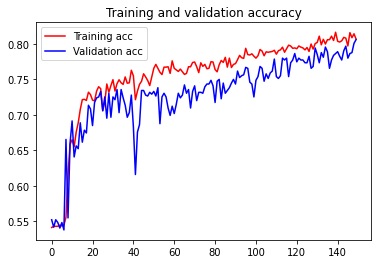

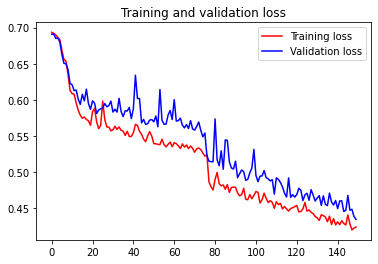

13/13 [==============================] - 0s 14ms/step - loss: 0.4394 - acc: 0.8020
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.43935921788215637, 0.8019925355911255]
              precision    recall  f1-score   support

           0     0.7833    0.7877    0.7855       179
           1     0.7564    0.7516    0.7540       157

    accuracy                         0.7708       336
   macro avg     0.7699    0.7697    0.7698       336
weighted avg     0.7708    0.7708    0.7708       336



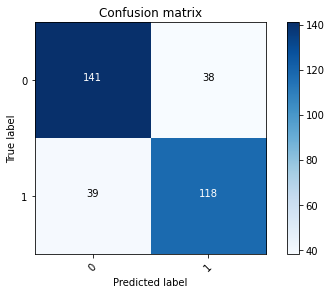

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))
model6.summary()

run_model(model6, 'model6', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 7
The change in the dense layer actually improved performance, which is also visible in the increased accuracy on the test set.

At this point we try to improve further by adding a convolutional layer with 128 filters and a size of 3x3.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

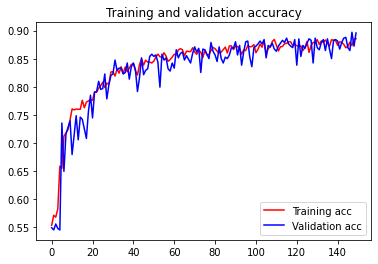

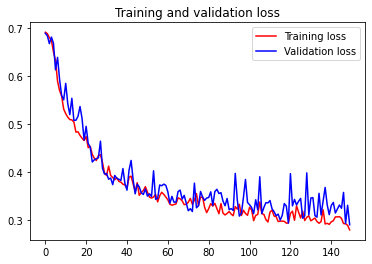

13/13 [==============================] - 0s 17ms/step - loss: 0.2903 - acc: 0.8954
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.29032251238822937, 0.8953922986984253]
              precision    recall  f1-score   support

           0     0.8482    0.9050    0.8757       179
           1     0.8828    0.8153    0.8477       157

    accuracy                         0.8631       336
   macro avg     0.8655    0.8602    0.8617       336
weighted avg     0.8643    0.8631    0.8626       336



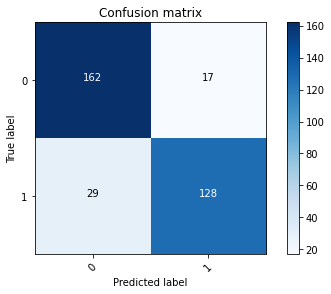

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model7 = models.Sequential()
model7.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model7.add(layers.MaxPooling2D((2, 2)))
model7.add(layers.Flatten())
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))
model7.summary()

run_model(model7, 'model7', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 8
Adding the last layer greatly improves the accuracy on the test set, so let's try adding another one with 256 filters and 3x3 size

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

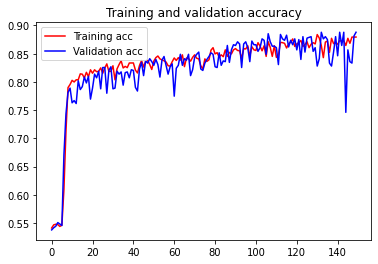

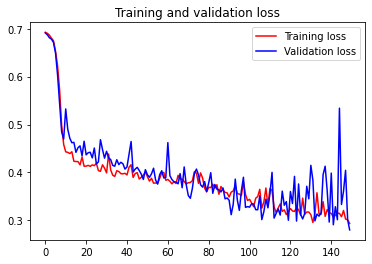

13/13 [==============================] - 0s 17ms/step - loss: 0.2769 - acc: 0.8904
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.27687814831733704, 0.8904109597206116]
              precision    recall  f1-score   support

           0     0.8548    0.8883    0.8712       179
           1     0.8667    0.8280    0.8469       157

    accuracy                         0.8601       336
   macro avg     0.8608    0.8581    0.8591       336
weighted avg     0.8604    0.8601    0.8599       336



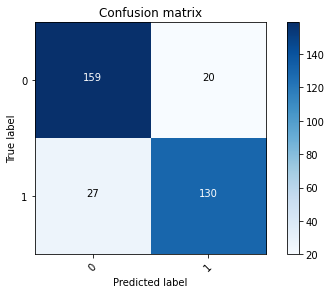

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model8 = models.Sequential()
model8.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dense(1, activation='sigmoid'))
model8.summary()

run_model(model8, 'model8', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 9
Let's try one more time to add another convolutional layer with 256 filters and 3x3 size.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

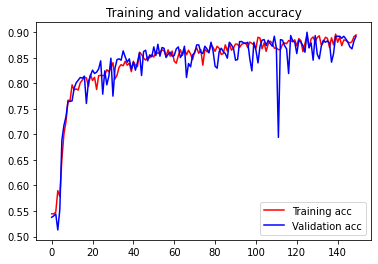

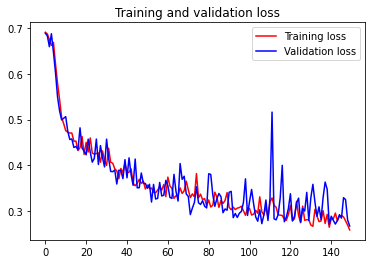

13/13 [==============================] - 0s 18ms/step - loss: 0.2630 - acc: 0.8941
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.26296842098236084, 0.8941469192504883]
              precision    recall  f1-score   support

           0     0.8500    0.8547    0.8524       179
           1     0.8333    0.8280    0.8307       157

    accuracy                         0.8423       336
   macro avg     0.8417    0.8414    0.8415       336
weighted avg     0.8422    0.8423    0.8422       336



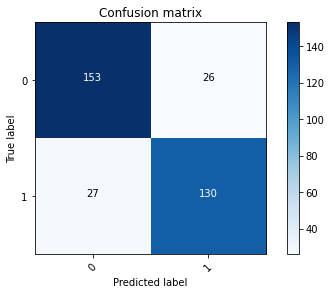

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model9 = models.Sequential()
model9.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(64, (3, 3), activation='relu'))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(128, (3, 3), activation='relu'))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(256, (3, 3), activation='relu'))
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Conv2D(256, (3, 3), activation='relu')) 
model9.add(layers.MaxPooling2D((2, 2)))
model9.add(layers.Flatten())
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dense(1, activation='sigmoid'))
model9.summary()

run_model(model9, 'model9', epoch = 150, adam = True, learning_rate = 0.0001) 

### Experiment 10
Since accuracy has dropped, we further modify the structure of the experiment 8 by adding a dense layer of 256 and change the other FC layer from 64 to 128 neurons.  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       2

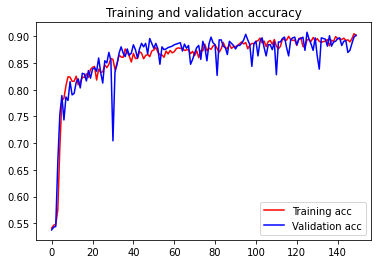

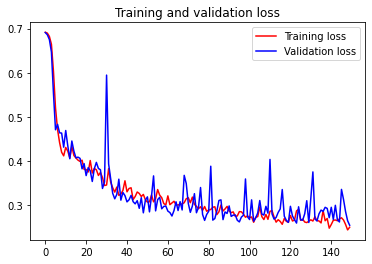

13/13 [==============================] - 0s 18ms/step - loss: 0.2521 - acc: 0.9029
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.2520886957645416, 0.9028642773628235]
              precision    recall  f1-score   support

           0     0.8617    0.9050    0.8828       179
           1     0.8851    0.8344    0.8590       157

    accuracy                         0.8720       336
   macro avg     0.8734    0.8697    0.8709       336
weighted avg     0.8727    0.8720    0.8717       336



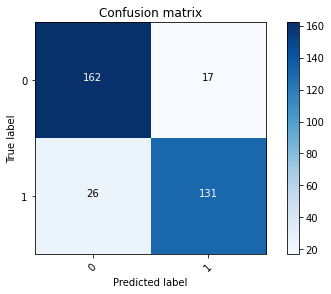

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model10 = models.Sequential()
model10.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(64, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(128, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Conv2D(256, (3, 3), activation='relu'))
model10.add(layers.MaxPooling2D((2, 2)))
model10.add(layers.Flatten())
model10.add(layers.Dense(256, activation='relu'))
model10.add(layers.Dense(128, activation='relu'))
model10.add(layers.Dense(1, activation='sigmoid'))
model10.summary()

run_model(model10, 'model10', epoch = 150, adam = True, learning_rate = 0.0001)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


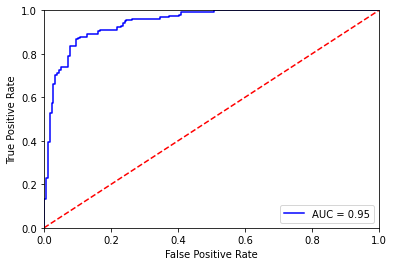

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model10_best.h5'))

probs = model.predict_proba(test_images)
fig2 = plt.figure()
fpr, tpr, threshold = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr) 
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Experiment 11

At this point we try to stabilise the last model using a DropOut layer with a rate of 0.3.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

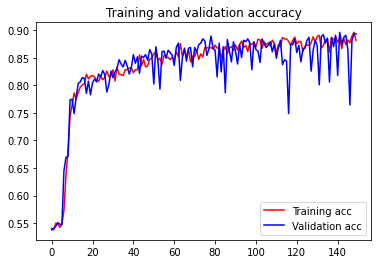

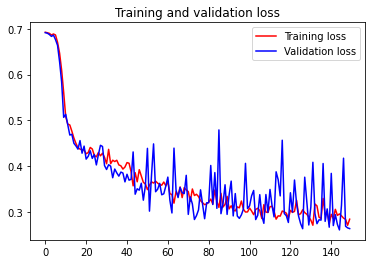

13/13 [==============================] - 0s 18ms/step - loss: 0.2595 - acc: 0.8929
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.2594733238220215, 0.892901599407196]
              precision    recall  f1-score   support

           0     0.8486    0.8771    0.8626       179
           1     0.8543    0.8217    0.8377       157

    accuracy                         0.8512       336
   macro avg     0.8515    0.8494    0.8501       336
weighted avg     0.8513    0.8512    0.8510       336



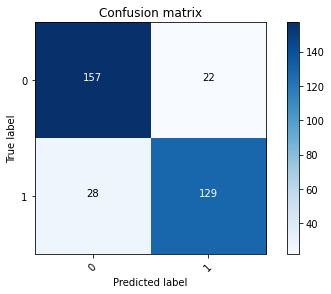

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model11 = models.Sequential()
model11.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(128, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(256, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Flatten())
model11.add(layers.Dropout(0.3))
model11.add(layers.Dense(128, activation='relu'))
model11.add(layers.Dropout(0.3))
model11.add(layers.Dense(64, activation='relu'))
model11.add(layers.Dropout(0.3))
model11.add(layers.Dense(1, activation='sigmoid'))
model11.summary()

run_model(model11, 'model11', epoch = 150, adam = True, learning_rate = 0.0001)

### Experiment 12
A final experiment we thought of is to increase the contrast of the images to see if the network can better learn and recognise the abnormality in the image.

In order to be able to perform this, we increased the contrast to the training, validation and test sets.

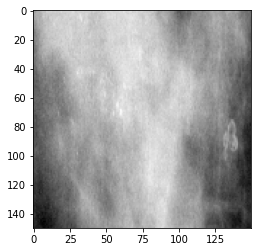

In [ ]:
# plot before increasing contrast
plt.imshow(train_images[0][:,:,0], cmap='gray')
plt.show()

In [ ]:
temp_train = train_images.copy()
for i in train_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

temp_valid = valid_images.copy()
for i in valid_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

temp_test = test_images.copy()
for i in test_images:
    i[:,:,0] = contrast_stretching(i[:,:,0])

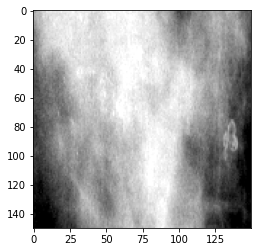

In [ ]:
# plot after increasing contrast
plt.imshow(train_images[0][:,:,0], cmap='gray')
plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       2

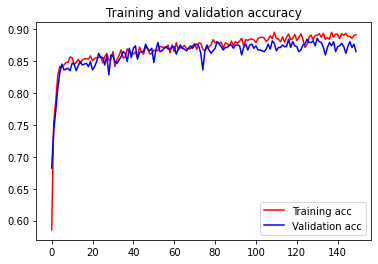

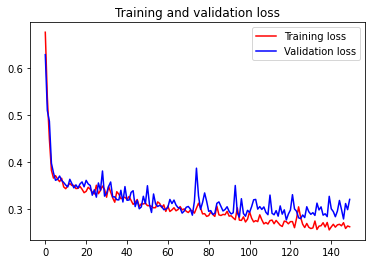

13/13 [==============================] - 0s 18ms/step - loss: 0.2817 - acc: 0.8767
Validation accuracy and loss of the best model
Validation loss, Validation acc: [0.2816857695579529, 0.8767123222351074]
              precision    recall  f1-score   support

           0     0.8603    0.8603    0.8603       179
           1     0.8408    0.8408    0.8408       157

    accuracy                         0.8512       336
   macro avg     0.8505    0.8505    0.8505       336
weighted avg     0.8512    0.8512    0.8512       336



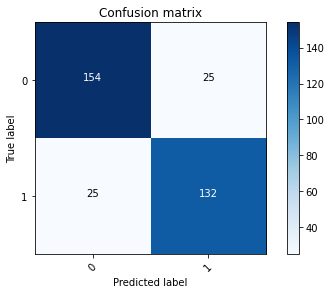

In [ ]:
set_seed()

train_datagen.fit(train_images)
train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

validation_generator = datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)
test_generator = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

model10_c = models.Sequential()
model10_c.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 1)))
model10_c.add(layers.MaxPooling2D((2, 2)))
model10_c.add(layers.Conv2D(64, (3, 3), activation='relu'))
model10_c.add(layers.MaxPooling2D((2, 2)))
model10_c.add(layers.Conv2D(128, (3, 3), activation='relu'))
model10_c.add(layers.MaxPooling2D((2, 2)))
model10_c.add(layers.Conv2D(256, (3, 3), activation='relu'))
model10_c.add(layers.MaxPooling2D((2, 2)))
model10_c.add(layers.Flatten())
model10_c.add(layers.Dense(256, activation='relu'))
model10_c.add(layers.Dense(128, activation='relu'))
model10_c.add(layers.Dense(1, activation='sigmoid'))
model10_c.summary()

run_model(model10_c, 'model10_c', epoch = 150, adam = True, learning_rate = 0.0001)

## Error Analysis
This last chapter summarises the errors made by the CNN built in the best model, i.e. experiment 10.

In [ ]:
train_images = temp_train.copy()
valid_images = temp_valid.copy()
test_images = temp_test.copy()

In [ ]:
import seaborn as sns

def get_errors(pred):
    errors = []
    mispred = []

    for l, p, img in zip(test_labels, pred, test_images):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))

    return errors, mispred

def show_error_stats(errors, mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))

    #sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==1 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        #plt.axis('off')

opt_model = models.load_model(os.path.join(MODEL_PATH, 'model10_best.h5'))
pred_opt = opt_model.predict(test_images)
errors, mispred = get_errors(pred_opt)
show_error_stats(errors, mispred)

Output hidden; open in https://colab.research.google.com to view.